In [0]:
SETUP = False

In [0]:
if SETUP:
    !pip install -q -U toai
    !pip install -q -U tensorflow-datasets
    !pip install -q -U --no-deps tensorflow-addons~=0.6
    !pip install -q kaggle

    

    !pip install tensorflow==2.0.0

    !pip install -q -U keras-tuner


        
    
    print(__import__("toai").__version__)
    print(__import__("tensorflow").__version__)

In [0]:
    !mkdir -p ~/.kaggle
    !cp kaggle.json ~/.kaggle/
    !chmod 600 ~/.kaggle/kaggle.json

In [0]:
from toai.imports import *
from toai.data import DataBundle, DataParams, DataContainer
import tensorflow as tf
from tensorflow import keras
import tensorflow_datasets as tfds
from toai.utils import download_file, unzip, save_file, load_file
from toai.metrics import rmse
import kerastuner as kt



In [0]:
from sklearn import preprocessing

In [0]:
from toai.data.utils import split_df

In [0]:
from toai.metrics import rmse



In [0]:
import matplotlib.pyplot as plt
plt.style.use('classic')
%matplotlib inline

In [0]:
DATA_DIR = Path("data/SteamGames")
DATA_DIR.mkdir(parents=True, exist_ok=True)

TEMP_DIR = Path("temp/SteamGames")
TEMP_DIR.mkdir(parents=True, exist_ok=True)

In [0]:
if SETUP:
    
    DATA_DIR.mkdir(parents=True, exist_ok=True)
    TEMP_DIR.mkdir(parents=True, exist_ok=True)
    kaggle.api.authenticate()
    kaggle.api.dataset_download_files(
        dataset="tamber/steam-video-games", path=DATA_DIR, unzip=True
    )

# Preprocessing

In [0]:
df = pd.read_csv(DATA_DIR/'steam-200k.csv')

In [0]:
#df_2 = pd.read_csv(DATA_DIR/'steam-200k.csv')

In [0]:
#df_2

In [13]:
df.head()

,151603712,The Elder Scrolls V Skyrim,purchase,1.0,0
0,151603712,The Elder Scrolls V Skyrim,play,273.0,0
1,151603712,Fallout 4,purchase,1.0,0
2,151603712,Fallout 4,play,87.0,0
3,151603712,Spore,purchase,1.0,0
4,151603712,Spore,play,14.9,0


In [0]:
df = df.drop(columns="0")

In [0]:
df.rename(columns={'151603712': 'ID', 'The Elder Scrolls V Skyrim': 'Game','1.0':'rating'}, inplace=True)

In [0]:
df = df[~df['purchase'].isin(['purchase'])]

In [0]:
df = df.drop(columns='purchase')

In [151]:
df.head()

,ID,Game,rating
0,151603712,The Elder Scrolls V Skyrim,273.0
2,151603712,Fallout 4,87.0
4,151603712,Spore,14.9
6,151603712,Fallout New Vegas,12.1
8,151603712,Left 4 Dead 2,8.9


In [0]:
enc = preprocessing.LabelEncoder()

In [0]:
df['Game'] = enc.fit_transform(df['Game'])


In [0]:
#df['ID'] = enc.fit_transform(df['ID'])

In [0]:
val_df['ID'] = enc.fit_transform(val_df['ID'])

In [0]:
train_df['ID'] = enc.fit_transform(train_df['ID'])

In [154]:
df.head()

,ID,Game,rating
0,151603712,3067,273.0
2,151603712,1162,87.0
4,151603712,2813,14.9
6,151603712,1163,12.1
8,151603712,1733,8.9


In [23]:
df.describe()

,ID,Game,rating
count,70489.000000,70489.000000,70489.000000
mean,3404.957766,1723.251131,48.878063
std,2906.701041,1044.097208,229.335236
min,0.000000,0.000000,0.100000
25%,1043.000000,828.000000,1.000000
50%,2503.000000,1578.000000,4.500000
75%,5268.000000,2717.000000,19.100000
max,11349.000000,3599.000000,11754.000000


In [24]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 70489 entries, 0 to 199998
Data columns (total 3 columns):
ID        70489 non-null int64
Game      70489 non-null int64
rating    70489 non-null float64
dtypes: float64(1), int64(2)
memory usage: 2.2 MB


In [25]:
len(df.ID.unique())

11350

In [156]:
df.isna().sum()

ID        0
Game      0
rating    0
dtype: int64

In [0]:
from toai.data.utils import split_df

In [0]:
train_df, val_df, test_df = split_df(df, 0.3)

In [28]:
[x.shape for x in (train_df, val_df, test_df)]

[(49342, 3), (10573, 3), (10574, 3)]

In [55]:
train_df['rating'].values[:5]

array([7.65703298e-05, 7.48602591e-02, 6.80625154e-05, 3.40312577e-05,
       8.50781443e-06])

In [0]:
scaler = MinMaxScaler(feature_range=(0,1))

In [31]:
scaler.fit(train_df[['rating']])

MinMaxScaler(copy=True, feature_range=(0, 1))

In [32]:
train_df['rating']=scaler.transform(train_df[['rating']]) 

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


In [33]:
df.head()

,ID,Game,rating
0,5088,3067,273.0
2,5088,1162,87.0
4,5088,2813,14.9
6,5088,1163,12.1
8,5088,1733,8.9


In [0]:
val_df['rating'] = scaler.transform(val_df[['rating']])

In [35]:
scaler.inverse_transform(train_df[['rating']][:10]).flatten()

array([1.00e+00, 8.80e+02, 9.00e-01, 5.00e-01, 2.00e-01, 5.00e-01,
       2.10e+00, 1.30e+00, 1.15e+01, 2.10e+00])

In [0]:
BATCH_SIZE = 256
AUTOTUNE = tf.data.experimental.AUTOTUNE

In [37]:
train_df["ID"].max(), val_df["ID"].max(),train_df["Game"].max(), val_df["Game"].max()

(11349, 11348, 3599, 3599)

In [0]:
df.head(5)

In [157]:
train_df.head()

,ID,Game,rating
0,50,2936,0.000077
1,144,1968,0.074860
2,208,1660,0.000068
3,156,234,0.000034
4,1443,1968,0.000009


In [0]:
n_users = 11350

In [0]:
n_games = 3600

In [0]:
target_col = 'rating'

In [0]:
train_dataset = (
    tf.data.Dataset.zip(
        (
            tf.data.Dataset.from_tensor_slices(
                (train_df["ID"].values, train_df["Game"].values)
            ),
            tf.data.Dataset.from_tensor_slices(train_df[target_col].values),
        )
    )
    .cache()
    .repeat()
    .shuffle(len(train_df))
    .batch(BATCH_SIZE)
    .prefetch(AUTOTUNE)
)

In [0]:
val_dataset = (
    tf.data.Dataset.zip(
        (
            tf.data.Dataset.from_tensor_slices(
                (train_df["ID"].values, train_df["Game"].values)
            ),
            tf.data.Dataset.from_tensor_slices(train_df[target_col].values),
        )
    )
    .batch(BATCH_SIZE)
    .prefetch(AUTOTUNE)
)

In [0]:
train_data_steps = len(train_df)//BATCH_SIZE

In [0]:
def make_concat_model(
    user_dim,
    item_dim,
    embedding_dim,
    layer_size=256,
    dropout_rate=0.0,
    regularization=None,
):
    user_input = keras.layers.Input(shape=(1,))
    user_embedding = keras.layers.Embedding(user_dim, embedding_dim, input_length=1,)(
        user_input
    )
    user_embedding = keras.layers.Flatten()(user_embedding)
    user_bias = keras.layers.Embedding(user_dim, 1, input_length=1,)(user_input)
    user_bias = keras.layers.Flatten()(user_bias)

    item_input = keras.layers.Input(shape=(1,))
    item_embedding = keras.layers.Embedding(item_dim, embedding_dim, input_length=1,)(
        item_input
    )
    item_embedding = keras.layers.Flatten()(item_embedding)
    item_bias = keras.layers.Embedding(item_dim, 1, input_length=1,)(item_input)
    item_bias = keras.layers.Flatten()(item_bias)

    x = keras.layers.Concatenate()(
        [user_embedding, user_bias, item_embedding, item_bias]
    )
    x = keras.layers.BatchNormalization()(x)
    x = keras.layers.Dropout(dropout_rate)(x)
    x = keras.layers.Dense(
        layer_size,
        kernel_initializer=keras.initializers.he_uniform(),
        kernel_regularizer=regularization and keras.regularizers.l1_l2(*regularization),
    )(x)
    x = keras.layers.LeakyReLU()(x)
    x = keras.layers.BatchNormalization()(x)
    x = keras.layers.Dropout(dropout_rate)(x)
    x = keras.layers.Dense(1)(x)
    outputs = keras.layers.Activation(keras.activations.sigmoid)(x)

    model = keras.Model(inputs=[user_input, item_input], outputs=outputs)
    return model

In [0]:
concat_model = make_concat_model(
    n_users,
    n_games,
    128,
    layer_size=256,
    dropout_rate=0.1,
    regularization=(1e-8, 1e-4),
)

In [46]:
concat_model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 1)]          0                                            
__________________________________________________________________________________________________
input_2 (InputLayer)            [(None, 1)]          0                                            
__________________________________________________________________________________________________
embedding (Embedding)           (None, 1, 128)       1452800     input_1[0][0]                    
__________________________________________________________________________________________________
embedding_1 (Embedding)         (None, 1, 1)         11350       input_1[0][0]                    
______________________________________________________________________________________________

In [0]:
concat_model.compile(
    optimizer=keras.optimizers.Adam(3e-4),
    loss=keras.losses.mse,
    metrics=[keras.metrics.mse,keras.metrics.mae],
)

In [76]:
PATIENCE = 4

concat_model_history = concat_model.fit(
    train_dataset,
    steps_per_epoch=train_data_steps,
    validation_data=val_dataset,
    epochs=20,
    callbacks=[
        tf.keras.callbacks.ReduceLROnPlateau(factor=0.3, patience=PATIENCE),
        tf.keras.callbacks.EarlyStopping(
            patience=PATIENCE * 2, restore_best_weights=True
        ),
    ],
    verbose=2,
)



Train for 192 steps, validate for 193 steps
Epoch 1/20
192/192 - 6s - loss: 0.0133 - mean_squared_error: 5.2163e-04 - mean_absolute_error: 0.0127 - val_loss: 0.0120 - val_mean_squared_error: 4.8562e-04 - val_mean_absolute_error: 0.0115
Epoch 2/20
192/192 - 6s - loss: 0.0108 - mean_squared_error: 4.6380e-04 - mean_absolute_error: 0.0113 - val_loss: 0.0097 - val_mean_squared_error: 4.3993e-04 - val_mean_absolute_error: 0.0098
Epoch 3/20
192/192 - 6s - loss: 0.0087 - mean_squared_error: 4.8201e-04 - mean_absolute_error: 0.0110 - val_loss: 0.0078 - val_mean_squared_error: 4.3322e-04 - val_mean_absolute_error: 0.0093
Epoch 4/20
192/192 - 6s - loss: 0.0071 - mean_squared_error: 5.4790e-04 - mean_absolute_error: 0.0107 - val_loss: 0.0063 - val_mean_squared_error: 4.0538e-04 - val_mean_absolute_error: 0.0079
Epoch 5/20
192/192 - 6s - loss: 0.0060 - mean_squared_error: 7.1095e-04 - mean_absolute_error: 0.0112 - val_loss: 0.0053 - val_mean_squared_error: 4.6578e-04 - val_mean_absolute_error: 0.0

In [0]:
concat_model_training_loss = concat_model_history.history['loss']
concat_model_val_loss = concat_model_history.history['val_loss']
epoch_count = range(1, len(concat_model_training_loss) + 1)

In [71]:
epoch_count

range(1, 11)

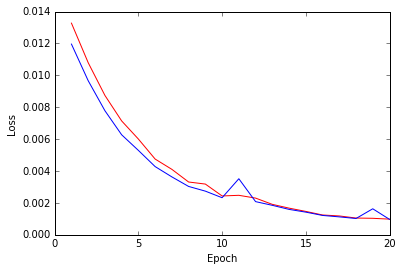

In [78]:
plt.plot(epoch_count, concat_model_training_loss, 'r')
plt.plot(epoch_count, concat_model_val_loss, 'b')

plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.show()

In [0]:
mse = concat_model_history.history['mean_absolute_error']
mae = concat_model_history.history['mean_squared_error']

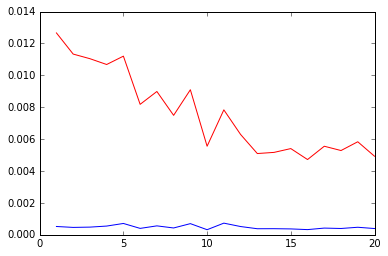

In [86]:
plt.plot(epoch_count, mse, 'r')
plt.plot(epoch_count, mae, 'b')

In [0]:
import matplotlib.pyplot as plt
plt.style.use('classic')
%matplotlib inline
#run more times to show graphs

# Dot model

In [0]:
def make_dot_model(
    user_dim, item_dim, embedding_dim,
):
    user_input = keras.layers.Input(shape=(1,))
    user_embedding = keras.layers.Embedding(user_dim, embedding_dim, input_length=1,)(
        user_input
    )
    user_embedding = keras.layers.Flatten()(user_embedding)
    user_bias = keras.layers.Embedding(user_dim, 1, input_length=1,)(user_input)
    user_bias = keras.layers.Flatten()(user_bias)

    item_input = keras.layers.Input(shape=(1,))
    item_embedding = keras.layers.Embedding(item_dim, embedding_dim, input_length=1,)(
        item_input
    )
    item_embedding = keras.layers.Flatten()(item_embedding)
    item_bias = keras.layers.Embedding(item_dim, 1, input_length=1,)(item_input)
    item_bias = keras.layers.Flatten()(item_bias)

    dot_product = keras.layers.Dot(axes=1)([user_embedding, item_embedding])
    logits = keras.layers.Add()([dot_product, user_bias, item_bias])
    outputs = keras.layers.Activation(keras.activations.sigmoid)(logits)

    model = keras.Model(inputs=[user_input, item_input], outputs=outputs)
    return model

In [0]:
dot_model = make_dot_model(n_users, n_games,128)

In [0]:
dot_model.compile(
    optimizer=keras.optimizers.Adam(3e-4),
    loss=keras.losses.mse,
    metrics=[keras.metrics.mae,keras.metrics.mse],
)



In [88]:
PATIENCE = 5

dot_model_history = dot_model.fit(
    train_dataset,
    steps_per_epoch=train_data_steps,
    validation_data=val_dataset,
    epochs=20,
    callbacks=[
        tf.keras.callbacks.ReduceLROnPlateau(factor=0.3, patience=PATIENCE),
        tf.keras.callbacks.EarlyStopping(
            patience=PATIENCE * 2, restore_best_weights=True
        ),
    ],
    verbose=2,
)



Train for 192 steps, validate for 193 steps
Epoch 1/20
192/192 - 4s - loss: 0.0010 - mean_absolute_error: 0.0215 - mean_squared_error: 0.0010 - val_loss: 0.0558 - val_mean_absolute_error: 0.1824 - val_mean_squared_error: 0.0558
Epoch 2/20
192/192 - 4s - loss: 9.2755e-04 - mean_absolute_error: 0.0202 - mean_squared_error: 9.2755e-04 - val_loss: 0.0551 - val_mean_absolute_error: 0.1801 - val_mean_squared_error: 0.0551
Epoch 3/20
192/192 - 4s - loss: 8.3341e-04 - mean_absolute_error: 0.0190 - mean_squared_error: 8.3341e-04 - val_loss: 0.0544 - val_mean_absolute_error: 0.1778 - val_mean_squared_error: 0.0544
Epoch 4/20
192/192 - 4s - loss: 7.3875e-04 - mean_absolute_error: 0.0178 - mean_squared_error: 7.3875e-04 - val_loss: 0.0537 - val_mean_absolute_error: 0.1757 - val_mean_squared_error: 0.0537
Epoch 5/20
192/192 - 4s - loss: 6.5759e-04 - mean_absolute_error: 0.0168 - mean_squared_error: 6.5759e-04 - val_loss: 0.0531 - val_mean_absolute_error: 0.1737 - val_mean_squared_error: 0.0531
Epoc

In [0]:
epoch_count_2 = range(1, len(dot_model_history.history['loss']) + 1)

In [0]:
dot_model_training_loss = dot_model_history.history['loss']
dot_model_val_loss = dot_model_history.history['val_loss']

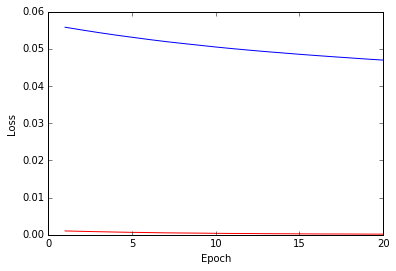

In [92]:
plt.plot(epoch_count, dot_model_training_loss, 'r')
plt.plot(epoch_count, dot_model_val_loss, 'b')

plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.show()

In [0]:
def make_combined_model(
    user_dim,
    item_dim,
    embedding_dim,
    layer_size=256,
    dropout_rate=0.0,
    regularization=None,
):
    user_input = keras.layers.Input(shape=(1,))
    user_embedding = keras.layers.Embedding(user_dim, embedding_dim, input_length=1,)(
        user_input
    )
    user_embedding = keras.layers.Flatten()(user_embedding)
    user_bias = keras.layers.Embedding(user_dim, 1, input_length=1,)(user_input)
    user_bias = keras.layers.Flatten()(user_bias)

    item_input = keras.layers.Input(shape=(1,))
    item_embedding = keras.layers.Embedding(item_dim, embedding_dim, input_length=1,)(
        item_input
    )
    item_embedding = keras.layers.Flatten()(item_embedding)
    item_bias = keras.layers.Embedding(item_dim, 1, input_length=1,)(item_input)
    item_bias = keras.layers.Flatten()(item_bias)

    x1 = keras.layers.Concatenate()(
        [user_embedding, user_bias, item_embedding, item_bias]
    )
    x1 = keras.layers.BatchNormalization()(x1)
    x1 = keras.layers.Dropout(dropout_rate)(x1)
    x1 = keras.layers.Dense(
        layer_size,
        kernel_initializer=keras.initializers.he_uniform(),
        kernel_regularizer=regularization and keras.regularizers.l1_l2(*regularization),
    )(x1)
    x1 = keras.layers.LeakyReLU()(x1)
    x1 = keras.layers.BatchNormalization()(x1)
    x1 = keras.layers.Dropout(dropout_rate)(x1)

    dot_product = keras.layers.Dot(axes=1)([user_embedding, item_embedding])
    x2 = keras.layers.Add()([dot_product, user_bias, item_bias])
    concat = keras.layers.Concatenate()([x1, x2])
    logits = keras.layers.Dense(1)(concat)
    outputs = keras.layers.Activation(keras.activations.sigmoid)(logits)

    model = keras.Model(inputs=[user_input, item_input], outputs=outputs)
    return model

In [0]:
combined_model = make_combined_model(
    n_users,
    n_games,
    128,
    layer_size=256,
    dropout_rate=0.2,
    regularization=(1e-8, 1e-4),
)



In [0]:
combined_model.compile(
    optimizer=keras.optimizers.Adam(3e-4),
    loss=keras.losses.mse,
    metrics=[keras.metrics.mae,keras.metrics.mse],
)

In [98]:
PATIENCE = 5

combined_model_history = combined_model.fit(
    train_dataset,
    steps_per_epoch=train_data_steps,
    validation_data=val_dataset,
    epochs=20,
    callbacks=[
        tf.keras.callbacks.ReduceLROnPlateau(factor=0.3, patience=PATIENCE),
        tf.keras.callbacks.EarlyStopping(
            patience=PATIENCE * 2, restore_best_weights=True
        ),
    ],
    verbose=2,
)

Train for 192 steps, validate for 193 steps
Epoch 1/20
192/192 - 7s - loss: 0.1628 - mean_absolute_error: 0.2932 - mean_squared_error: 0.1147 - val_loss: 0.0723 - val_mean_absolute_error: 0.1599 - val_mean_squared_error: 0.0258
Epoch 2/20
192/192 - 7s - loss: 0.0746 - mean_absolute_error: 0.1315 - mean_squared_error: 0.0296 - val_loss: 0.0483 - val_mean_absolute_error: 0.0665 - val_mean_squared_error: 0.0047
Epoch 3/20
192/192 - 7s - loss: 0.0519 - mean_absolute_error: 0.0684 - mean_squared_error: 0.0097 - val_loss: 0.0424 - val_mean_absolute_error: 0.0372 - val_mean_squared_error: 0.0017
Epoch 4/20
192/192 - 7s - loss: 0.0438 - mean_absolute_error: 0.0436 - mean_squared_error: 0.0046 - val_loss: 0.0385 - val_mean_absolute_error: 0.0251 - val_mean_squared_error: 9.5382e-04
Epoch 5/20
192/192 - 7s - loss: 0.0386 - mean_absolute_error: 0.0315 - mean_squared_error: 0.0027 - val_loss: 0.0350 - val_mean_absolute_error: 0.0188 - val_mean_squared_error: 6.6656e-04
Epoch 6/20
192/192 - 7s - lo

In [0]:
comb_model_training_loss = combined_model_history.history['loss']
comb_model_val_loss = combined_model_history.history['val_loss']
epoch_count_3 = range(1, len(comb_model_training_loss) + 1)

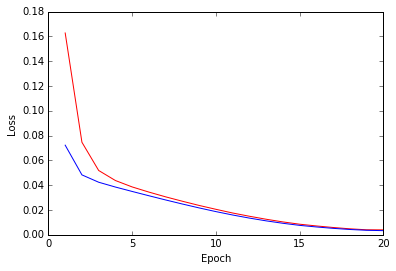

In [102]:
plt.plot(epoch_count, comb_model_training_loss, 'r')
plt.plot(epoch_count, comb_model_val_loss, 'b')

plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.show()

# HP

In [0]:
class EmbeddingLayer:
    def __init__(
        self,
        input_dim: int,
        embedding_dim: int,
        embeddings_regularization_l2: float = 0.0,
    ):
        self.input_dim = input_dim
        self.embedding_dim = embedding_dim
        self.embeddings_regularization_l2 = embeddings_regularization_l2

    def __call__(self, layer: keras.layers.Layer) -> keras.layers.Layer:
        layer = keras.layers.Embedding(
            self.input_dim,
            self.embedding_dim,
            input_length=(1,),
            embeddings_regularizer=keras.regularizers.l2(
                self.embeddings_regularization_l2
            ),
        )(layer)
        return keras.layers.Flatten()(layer)

In [0]:
def make_combined_modelhp(hp):
    embedding_dim = hp.Choice("embedding_dim", [16, 32, 64, 128,256])
    user_dim = hp.Fixed("user_dim", 1)
    item_dim = hp.Fixed("item_dim", 1)
    user_input = keras.layers.Input(shape=(1,))
    user_embedding = EmbeddingLayer(
        user_dim,
        embedding_dim,
        hp.Float(
            "user_embeddings_regularization_l2",
            min_value=1e-8,
            max_value=5e-2,
            sampling="log",
        ),
    )(user_input)
    user_bias = EmbeddingLayer(user_dim, 1)(user_input)

    item_input = keras.layers.Input(shape=(1,))
    item_embedding = EmbeddingLayer(
        item_dim,
        embedding_dim,
        hp.Float(
            "item_embeddings_regularization_l2",
            min_value=1e-8,
            max_value=5e-2,
            sampling="log",
        ),
    )(item_input)
    item_bias = EmbeddingLayer(item_dim, 1)(item_input)

    x1 = keras.layers.Concatenate()(
        [user_embedding, user_bias, item_embedding, item_bias]
    )
    x1 = keras.layers.BatchNormalization()(x1)
    x1 = keras.layers.Dropout(
        hp.Float("dropout_rate1", min_value=0.0, max_value=0.8, step=0.1)
    )(x1)
    x1 = keras.layers.Dense(
        hp.Choice("layer_size", [16, 32, 64, 128, 256]),
        kernel_initializer=keras.initializers.he_uniform(),
        kernel_regularizer=keras.regularizers.l2(
            hp.Float(
                "kernel_regularizer", min_value=1e-8, max_value=1e-2, sampling="log"
            )
        ),
    )(x1)
    x1 = keras.layers.LeakyReLU()(x1)
    x1 = keras.layers.BatchNormalization()(x1)
    x1 = keras.layers.Dropout(
        hp.Float("dropout_rate2", min_value=0.0, max_value=0.8, step=0.1)
    )(x1)

    dot_product = keras.layers.Dot(axes=1)([user_embedding, item_embedding])
    x2 = keras.layers.Add()([dot_product, user_bias, item_bias])
    concat = keras.layers.Concatenate()([x1, x2])
    logits = keras.layers.Dense(1)(concat)
    outputs = keras.layers.Activation(
        hp.Choice("final_activation", ["sigmoid", "linear"])
    )(logits)

    model = keras.Model(inputs=[user_input, item_input], outputs=outputs)

    model.compile(
        optimizer=keras.optimizers.Adam(
            hp.Choice("learning_rate", [3e-3, 1e-3, 5e-4, 3e-4, 1e-4])
        ),
        loss=keras.losses.mse,
        metrics=[keras.metrics.mae],
    )
    return model

In [0]:
hp = kt.HyperParameters()
hp.Fixed("user_dim", n_users)
hp.Fixed("item_dim", n_games)

tuner = kt.tuners.RandomSearch(
    make_combined_model3,
    objective="val_loss",
    max_trials=30,
    tune_new_entries=True,
    hyperparameters=hp,
    directory=TEMP_DIR,
    project_name="combined_modehp",
)

In [129]:
tuner.search_space_summary()

In [130]:
PATIENCE = 2

tuner.search(
    train_dataset,
    steps_per_epoch=train_data_steps,
    validation_data=val_dataset,
    epochs=25,
    callbacks=[
        tf.keras.callbacks.ReduceLROnPlateau(factor=0.3, patience=PATIENCE),
        tf.keras.callbacks.EarlyStopping(
            patience=PATIENCE * 2, restore_best_weights=True
        ),
    ],
    verbose=0,
)

/usr/local/lib/python3.6/dist-packages/tensorflow_core/python/framework/indexed_slices.py:424: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "


/usr/local/lib/python3.6/dist-packages/tensorflow_core/python/framework/indexed_slices.py:424: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "


/usr/local/lib/python3.6/dist-packages/tensorflow_core/python/framework/indexed_slices.py:424: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "
/usr/local/lib/python3.6/dist-packages/tensorflow_core/python/framework/indexed_slices.py:424: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "


/usr/local/lib/python3.6/dist-packages/tensorflow_core/python/framework/indexed_slices.py:424: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "
/usr/local/lib/python3.6/dist-packages/tensorflow_core/python/framework/indexed_slices.py:424: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "


/usr/local/lib/python3.6/dist-packages/tensorflow_core/python/framework/indexed_slices.py:424: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "
/usr/local/lib/python3.6/dist-packages/tensorflow_core/python/framework/indexed_slices.py:424: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "


/usr/local/lib/python3.6/dist-packages/tensorflow_core/python/framework/indexed_slices.py:424: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "
/usr/local/lib/python3.6/dist-packages/tensorflow_core/python/framework/indexed_slices.py:424: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "


/usr/local/lib/python3.6/dist-packages/tensorflow_core/python/framework/indexed_slices.py:424: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "
/usr/local/lib/python3.6/dist-packages/tensorflow_core/python/framework/indexed_slices.py:424: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "


/usr/local/lib/python3.6/dist-packages/tensorflow_core/python/framework/indexed_slices.py:424: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "
/usr/local/lib/python3.6/dist-packages/tensorflow_core/python/framework/indexed_slices.py:424: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "


/usr/local/lib/python3.6/dist-packages/tensorflow_core/python/framework/indexed_slices.py:424: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "
/usr/local/lib/python3.6/dist-packages/tensorflow_core/python/framework/indexed_slices.py:424: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "


/usr/local/lib/python3.6/dist-packages/tensorflow_core/python/framework/indexed_slices.py:424: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "
/usr/local/lib/python3.6/dist-packages/tensorflow_core/python/framework/indexed_slices.py:424: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "


/usr/local/lib/python3.6/dist-packages/tensorflow_core/python/framework/indexed_slices.py:424: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "
/usr/local/lib/python3.6/dist-packages/tensorflow_core/python/framework/indexed_slices.py:424: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "


/usr/local/lib/python3.6/dist-packages/tensorflow_core/python/framework/indexed_slices.py:424: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "
/usr/local/lib/python3.6/dist-packages/tensorflow_core/python/framework/indexed_slices.py:424: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "


/usr/local/lib/python3.6/dist-packages/tensorflow_core/python/framework/indexed_slices.py:424: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "
/usr/local/lib/python3.6/dist-packages/tensorflow_core/python/framework/indexed_slices.py:424: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "


/usr/local/lib/python3.6/dist-packages/tensorflow_core/python/framework/indexed_slices.py:424: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "
/usr/local/lib/python3.6/dist-packages/tensorflow_core/python/framework/indexed_slices.py:424: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "


/usr/local/lib/python3.6/dist-packages/tensorflow_core/python/framework/indexed_slices.py:424: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "
/usr/local/lib/python3.6/dist-packages/tensorflow_core/python/framework/indexed_slices.py:424: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "


/usr/local/lib/python3.6/dist-packages/tensorflow_core/python/framework/indexed_slices.py:424: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "
/usr/local/lib/python3.6/dist-packages/tensorflow_core/python/framework/indexed_slices.py:424: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "


/usr/local/lib/python3.6/dist-packages/tensorflow_core/python/framework/indexed_slices.py:424: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "
/usr/local/lib/python3.6/dist-packages/tensorflow_core/python/framework/indexed_slices.py:424: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "


/usr/local/lib/python3.6/dist-packages/tensorflow_core/python/framework/indexed_slices.py:424: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "
/usr/local/lib/python3.6/dist-packages/tensorflow_core/python/framework/indexed_slices.py:424: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "


/usr/local/lib/python3.6/dist-packages/tensorflow_core/python/framework/indexed_slices.py:424: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "
/usr/local/lib/python3.6/dist-packages/tensorflow_core/python/framework/indexed_slices.py:424: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "


/usr/local/lib/python3.6/dist-packages/tensorflow_core/python/framework/indexed_slices.py:424: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "
/usr/local/lib/python3.6/dist-packages/tensorflow_core/python/framework/indexed_slices.py:424: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "


/usr/local/lib/python3.6/dist-packages/tensorflow_core/python/framework/indexed_slices.py:424: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "
/usr/local/lib/python3.6/dist-packages/tensorflow_core/python/framework/indexed_slices.py:424: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "


KeyboardInterrupt: ignored

In [0]:
class MeanModel(keras.Model):
    def __init__(self, mean):
        super().__init__()
        self.mean = tf.constant(mean, dtype=tf.float32)

    def call(self, inputs):
        return tf.ones_like(inputs[0], dtype=tf.float32) * self.mean

In [0]:
mean_model = MeanModel(train_df[target_col].mean())



In [0]:
mean_model.compile(
    optimizer=keras.optimizers.Adam(3e-4), loss=keras.losses.mse,
)

In [135]:
mean_model.predict(val_dataset)

array([[0.00416223],
       [0.00416223],
       [0.00416223],
       ...,
       [0.00416223],
       [0.00416223],
       [0.00416223]], dtype=float32)

In [0]:
def evaluate_predictions(model, dataset, scaler, metric):
    y_true = np.concatenate(
        [scaler.inverse_transform(y.numpy().reshape(-1, 1)) for _, y in dataset]
    )
    y_pred = scaler.inverse_transform(model.predict(dataset))
    return metric(y_true, y_pred)

In [138]:
for model in [concat_model, dot_model, combined_model, mean_model]:
    print(evaluate_predictions(model, val_dataset, scaler, rmse))

243.45971523988126
2546.9493739317354
230.19584440720678
227.22217521183185


In [0]:
test_df[target_col] = scaler.transform(test_df[[target_col]])

In [0]:
test_dataset = (
    tf.data.Dataset.zip(
        (
            tf.data.Dataset.from_tensor_slices(
                (test_df["ID"].values, test_df["Game"].values)
            ),
            tf.data.Dataset.from_tensor_slices(test_df[target_col].values),
        )
    )
    .batch(BATCH_SIZE)
    .prefetch(AUTOTUNE)
)

In [142]:
for model in [concat_model, dot_model, combined_model, mean_model]:
    print(evaluate_predictions(model, test_dataset, scaler, rmse))



230.77545430492364
1767.7289337804978
228.59127311563665
225.77646439304937


In [0]:
tuned_models = tuner.get_best_models(num_models=2)

In [145]:
[tuned_models[i].evaluate(val_dataset) for i in range(2)]

193/193 [==============================] - 1s 4ms/step - loss: 4.3334e-04 - mean_absolute_error: 0.0060


[[0.0004226465981997733, 0.0072327917], [0.0004333405230837329, 0.0060124854]]

In [146]:
for model in tuned_models:
    print(evaluate_predictions(model, test_dataset, scaler, rmse))

223.45267737523324
223.4401995648267


In [155]:
for model in [concat_model, dot_model, combined_model, mean_model]:
    print(evaluate_predictions(model, test_dataset, scaler, rmse))

230.77545430492364
1767.7289337804978
228.59127311563665
225.77646439304937
